# ResNet18 모델 구조를 활용하여 개미와 벌 이미지 분류하기

>1. 모듈 임포트
>2. 장비 확인
>3. 개미와 벌 이미지 데이터 불러오기  
>4. 데이터 확인하기
>5. 학습데이터에 대한 모델 성능을 확인하는 함수 정의
>6. 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
>7. ResNet18 모델 불러오고 Output 크기 설정
>8. Optimizer, Objective function 설정하기
>9. 학습되지 않은 ResNet18 모델로 학습 실행하고 성능 확인하기
>10. 학습된 ResNet18 모델에 개미와 벌 이미지 데이터에 맞게 fine-tuning(재학습)

## 1.  모듈 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

## 2. 장비 확인

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version :', torch.__version__, ' Device :',DEVICE)

Using PyTorch version : 1.7.0+cu101  Device : cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

## 3. 개미와 벌 이미지 데이터 불러오기

**train**
>- 224 * 224 사이즈로 이미지 변경. 변경되는 이미지 픽셀 값은 랜덤으로 선택
>- 50% 확률로 이미지 좌우 반전
>- 0~1사이의 값으로 정규화하고 텐서 형태로 데이터 변경
>- r,g,b 순으로 평균 0.5, 표준편차 0.5씩 적용



**val**
>- 이미지 중앙을 기준으로 224 * 224 크기로 이미지를 잘라내어 사이즈 변경
>- 이미지를 256 * 256 크기로 사이즈 변경
>- 0~1사이의 값으로 정규화하고 텐서 형태로 데이터 변경
>- r,g,b 순으로 평균 0.5, 표준편차 0.5씩 적용

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# 이미지 데이터 불러오기
image_datasets = {x: datasets.ImageFolder("../data/hymenoptera_data",
                                         data_transforms[x]) for x in ['train','val']}

# Mini-batch 단위로 데이터 구분
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = BATCH_SIZE,
                                              num_workers = 0,
                                              shuffle = True) for x in ['train','val']}

## 4. 데이터 확인하기

In [5]:
for (X_train, y_train) in dataloaders['train']:
    print('X_train:', X_train.size(), 'type:',X_train.type())
    print('y_train:', y_train.size(), 'type:',y_train.type())
    break

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

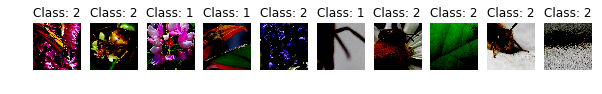

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1,2,0)))
    plt.title('Class: '+ str(y_train[i].item()))

## 5. 학습데이터에 대한 모델 성능을 확인하는 함수 정의

- 모델을 학습상태로 지정
- 미니배치 단위로 학습 진행
- 이미지 데이터와 라벨 데이터를 기존에 정의한 장비에 할당
- Optimizer의 grad 초기화
- 이미지 데이터를 모델의 input으로 이용하여 output 계산
- CrossEntropy를 이용하여 Loss 계산 후 역전파
- 파라미터 업데이트

In [7]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate (train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train EPOCH:{} [{}/{}({:.0f}%)]\tTrain Loss:{:.6f}".format(
                Epoch, batch_idx * len(image), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

## 6. 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

- 모델을 평가상태로 지정
- 미니배치 단위로 학습 진행
- Gradient의 흐름 억제
- 이후 과정은 *5. 학습 데이터에 대한 모델 성능을 확인하는 함수 정의* 와 동일

In [8]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    
    test_loss /= len(test_loader.dataset)
    test_accuracy =  100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 7. ResNet18 모델 불러오고 Output 크기 설정


- torchvision.models 내에 있는 models.resnet18 모델을 불러온다. 이때 **pretrained = False**로 설정하여 모델의 구조만 불러오고 모델 구조 내에 있는 파라미터는 특정 initializer에서 랜덤으로 샘플링한 값을 이용한다.
- resnet18 모델의 Fully Connected Layer의 input에 해당하는 노드 수를 num_ftrs로 저장한다.
- 개미와 벌 이미지를 분류하기 위해 최종 output의 노드 수는 2로 설정한다.

In [9]:
import torchvision.models as models
model = models.resnet18(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 8. Optimizer, Objective function 설정하기

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 9. 학습되지 않은 ResNet18 모델의 성능 확인하기

In [11]:
for Epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}],\tTest Loss: {:.4f},\tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train EPOCH:1 [0/397(0%)]	Train Loss:0.642896
Train EPOCH:1 [160/397(38%)]	Train Loss:0.684748
Train EPOCH:1 [320/397(77%)]	Train Loss:0.920888

[EPOCH: 1],	Test Loss: 0.0224,	Test Accuracy: 57.18 %

Train EPOCH:2 [0/397(0%)]	Train Loss:0.697294
Train EPOCH:2 [160/397(38%)]	Train Loss:0.735054
Train EPOCH:2 [320/397(77%)]	Train Loss:0.755891

[EPOCH: 2],	Test Loss: 0.0218,	Test Accuracy: 61.46 %

Train EPOCH:3 [0/397(0%)]	Train Loss:0.687885
Train EPOCH:3 [160/397(38%)]	Train Loss:0.674007
Train EPOCH:3 [320/397(77%)]	Train Loss:0.644740

[EPOCH: 3],	Test Loss: 0.0221,	Test Accuracy: 60.20 %

Train EPOCH:4 [0/397(0%)]	Train Loss:0.593875
Train EPOCH:4 [160/397(38%)]	Train Loss:0.797800
Train EPOCH:4 [320/397(77%)]	Train Loss:0.727339

[EPOCH: 4],	Test Loss: 0.0233,	Test Accuracy: 62.22 %

Train EPOCH:5 [0/397(0%)]	Train Loss:0.703118
Train EPOCH:5 [160/397(38%)]	Train Loss:0.684273
Train EPOCH:5 [320/397(77%)]	Train Loss:0.673077

[EPOCH: 5],	Test Loss: 0.0204,	Test Accuracy: 64.74 %



## 10. 학습된 ResNet18 모델에 개미와 벌 이미지 데이터에 맞게 fine-tuning(재학습)하기

- 미리 학습된 파라미터 값을 불러오기 위해 pretrained = True로 조정한다.

In [12]:
import torchvision.models as models
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10

In [13]:
for Epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}],\tTest Loss: {:.4f},\tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train EPOCH:1 [0/397(0%)]	Train Loss:0.706860
Train EPOCH:1 [160/397(38%)]	Train Loss:0.743938
Train EPOCH:1 [320/397(77%)]	Train Loss:0.836613

[EPOCH: 1],	Test Loss: 0.0207,	Test Accuracy: 65.99 %

Train EPOCH:2 [0/397(0%)]	Train Loss:0.594353
Train EPOCH:2 [160/397(38%)]	Train Loss:0.534291
Train EPOCH:2 [320/397(77%)]	Train Loss:0.611915

[EPOCH: 2],	Test Loss: 0.0165,	Test Accuracy: 76.83 %

Train EPOCH:3 [0/397(0%)]	Train Loss:0.453582
Train EPOCH:3 [160/397(38%)]	Train Loss:0.513375
Train EPOCH:3 [320/397(77%)]	Train Loss:0.578942

[EPOCH: 3],	Test Loss: 0.0142,	Test Accuracy: 80.86 %

Train EPOCH:4 [0/397(0%)]	Train Loss:0.555551
Train EPOCH:4 [160/397(38%)]	Train Loss:0.382328
Train EPOCH:4 [320/397(77%)]	Train Loss:0.522090

[EPOCH: 4],	Test Loss: 0.0119,	Test Accuracy: 86.40 %

Train EPOCH:5 [0/397(0%)]	Train Loss:0.376407
Train EPOCH:5 [160/397(38%)]	Train Loss:0.304975
Train EPOCH:5 [320/397(77%)]	Train Loss:0.244478

[EPOCH: 5],	Test Loss: 0.0095,	Test Accuracy: 89.92 %

